In [1]:
%matplotlib inline

## Variations of Half-life regression (HLR)

short-hand for each record \begin{align}<\cdot>&=<\Delta,x,P[\text{recall}]\in[0,1]>\\&=<\Delta,x,y\in\{0,1\}>\end{align}

Regression against recall probability $$l_\text{recall}(<\cdot>;\theta)=(p-f_\theta(x,\Delta))^2$$

Regression against back-solved half-life $$l_\text{half-life}(<\cdot>;\theta)=(\frac{-\Delta}{\log_2{p}}-f_\theta(x,\Delta))^2$$

Binary recall classification $$l_\text{binary}(<\cdot>;\theta)=\text{xent}(f_\theta(x,\Delta),y)$$

Assume that half-life increases exponentially with each repeated exposure, with a linear approximator, you get $f_\theta(x,\Delta)=2^{\theta\cdot x}$. Use this parameterization with regression against both recall probability and back-solved half-life, you get Settles' formulation:
$$l(<\cdot>; \theta)=(p-2^{\frac{\Delta}{2^{\theta\cdot x}}})^2+\alpha(\frac{\Delta}{\log_2(p)}-2^{\theta\cdot{x}})^2+\lambda|\theta|_2^2$$

In [3]:
import pickle
import numpy as np
import pandas as pd
from plotnine import *

In [4]:
class theme_fs(theme_light):
    """
    A theme similar to :class:`theme_linedraw` but with light grey
    lines and axes to direct more attention towards the data.
    Parameters
    ----------
    base_size : int, optional
        Base font size. All text sizes are a scaled versions of
        the base font size. Default is 11.
    base_family : str, optional
        Base font family.
    """

    def __init__(self, base_size=11, base_family='DejaVu Sans'):
        theme_light.__init__(self, base_size, base_family)
        self.add_theme(theme(
            axis_ticks=element_line(color='#DDDDDD', size=0.5),
            panel_border=element_rect(fill='None', color='#838383',
                                      size=1),
            strip_background=element_rect(
                fill='#DDDDDD', color='#838383', size=1),
            strip_text_x=element_text(color='black'),
            strip_text_y=element_text(color='black', angle=-90),
            legend_key=element_blank(),
        ), inplace=True)

In [58]:
from retention import get_split_dfs
train_df, test_df = get_split_dfs()

loading train test df


In [59]:
test_df

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,f_history_seen,f_history_correct,session_seen,session_correct,half_life,f_history_correct_sqrt,f_history_wrong_sqrt,bias
11568803,0.999900,1363009539,32.750220,u:dHVF,fr,en,ccf02ea2e390aea793ebf62b0c490075,<*sf>/indispensable<adj><mf><*numb>,2,2,1,1,274.000000,1.732051,1.000000,1
11568804,0.999900,1363009539,22.847269,u:dHVF,fr,en,97835f097be96da3ccb1e9b014b482fc,<*sf>/faux<adj><*gndr><*numb>,3,3,1,1,274.000000,2.000000,1.000000,1
11568805,0.999900,1363009539,22.847269,u:dHVF,fr,en,9c5f150b7ade77c73c8042af28b65ac0,<*sf>/tel<adj><*gndr><*numb>,2,1,1,1,274.000000,1.414214,1.414214,1
11568806,0.999900,1363009539,22.847269,u:dHVF,fr,en,1932e8abc8d82e23f343cdc4d84b8bbe,<*sf>/juste<adj><mf><*numb>,1,1,1,1,274.000000,1.414214,1.000000,1
11568807,0.999900,1363009539,24.962951,u:dHVF,fr,en,1f143f9a64cb3dd127ffc89c71840f55,<*sf>/fin<adj><*gndr><*numb>,1,1,1,1,274.000000,1.414214,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854221,0.800000,1363104897,0.004259,u:i5D8,en,it,d5efc552aaea3109eb5388aa1ec8673d,the/the<det><def><sp>,6,4,5,4,0.013230,2.236068,1.732051,1
12854222,0.800000,1363104897,0.004259,u:i5D8,en,it,a826c47947d68549fa81e19cafa57ba0,eat/eat<vblex><pres>,4,4,5,4,0.013230,2.236068,1.000000,1
12854223,0.999900,1363104897,0.004259,u:i5D8,en,it,5e29d77697d23070a1fb92eb6c90e9b6,bread/bread<n><sg>,4,4,4,4,29.521459,2.236068,1.000000,1
12854224,0.600000,1363104897,0.004259,u:i5D8,en,it,cdfecc9247566d40bb964a218c54c783,drink/drink<vblex><pres>,3,2,5,3,0.010417,1.732051,1.414214,1


In [64]:
with open('checkpoints/predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)
test_df['pp'] = np.array(predictions)
results = test_df

/fs/clip-quiz/shifeng/anaconda/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 2 rows containing missing values.
  data = self.position.setup_data(self.data, params)


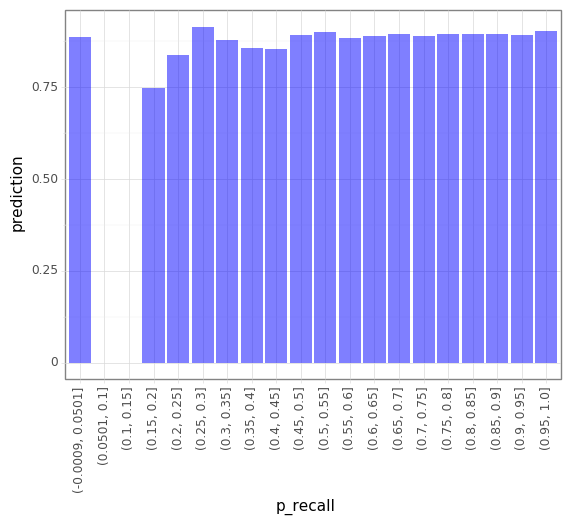

<ggplot: (8775240830633)>

In [65]:
def _bin_prediction(group):
    return pd.DataFrame([{'prediction':  group.pp.mean()}])

(
    ggplot(
        results.groupby(
            pd.cut(results.p_recall, 20)
        ).apply(_bin_prediction).reset_index()
    )
    + geom_bar(
        aes(x='p_recall', y='prediction'),
        stat='identity',
        fill='blue',
        alpha=0.5
    )
    + theme_fs()
    + theme(
        axis_text_x=element_text(rotation=90)
    )
)

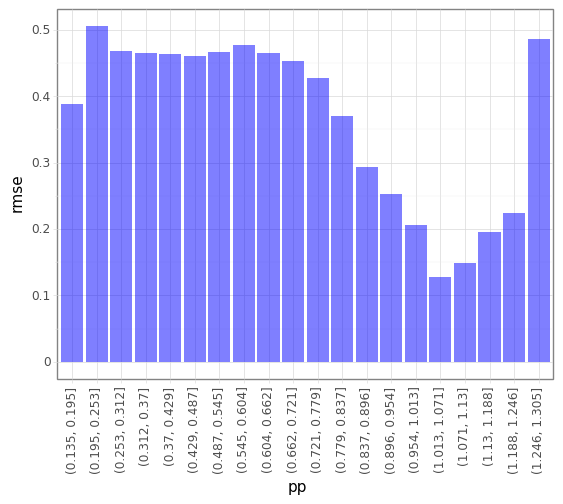

<ggplot: (8775339540377)>

In [68]:
def _bin_rmse(group):
    return pd.DataFrame([{
        'rmse':  ((group.pp - group.p_recall) ** 2).mean() ** (1/2)
    }])

(
    ggplot(
        results.groupby(
            pd.cut(results.pp, 20)
        ).apply(_bin_rmse).reset_index()
    )
    + geom_bar(
        aes(x='pp', y='rmse'),
        stat='identity',
        fill='blue',
        alpha=0.5
    )
    + theme_fs()
    + theme(
        axis_text_x=element_text(rotation=90)
    )
)

expected calibration error 0.3646671189163275


/fs/clip-quiz/shifeng/anaconda/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 1 rows containing missing values.
  data = self.position.setup_data(self.data, params)


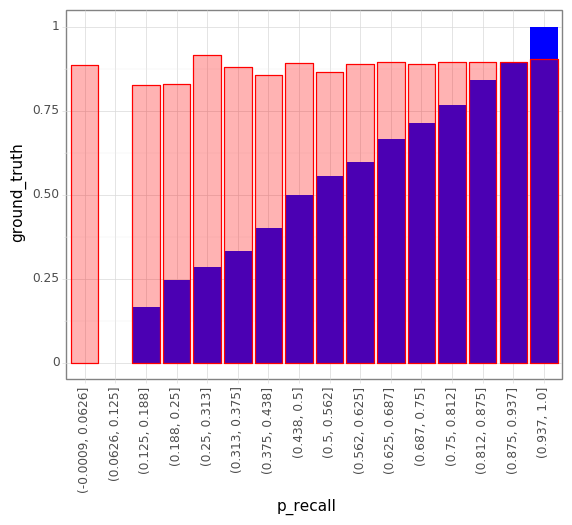

<ggplot: (8775329898513)>

In [72]:
def _bin_miscalibration(group):
    return pd.DataFrame([{
        'miscalibration': (group.pp - group.p_recall).abs().mean(),
        'prediction': group.pp.mean(),
        'ground_truth': group.p_recall.mean()
    }])

miscalibration = results.groupby(
    pd.cut(results.p_recall, 16)).apply(_bin_miscalibration).reset_index()

print('expected calibration error', miscalibration.miscalibration.mean())

(
    ggplot(miscalibration)
    + geom_bar(
        aes(x='p_recall', y='ground_truth'),
        stat='identity',
        fill='blue',
        alpha=1.0
    )
    + geom_bar(
        aes(x='p_recall', y='prediction'),
        stat='identity',
        fill='red',
        color='red',
        alpha=0.3
    )
    + theme_fs()
    + theme(
        axis_text_x=element_text(rotation=90)
    )
)

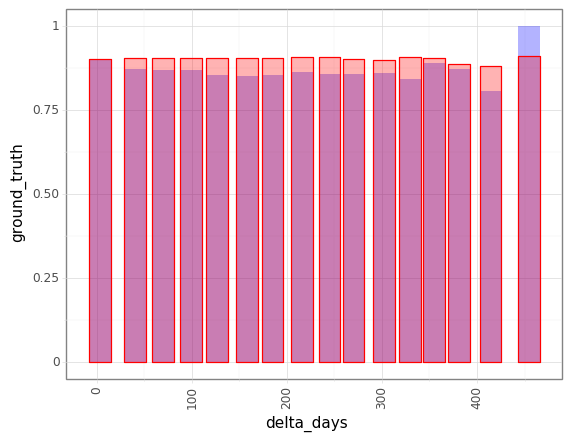

<ggplot: (8775337554261)>

In [73]:
def _bin_delta(group):
    return pd.DataFrame([{
        'prediction': group.pp.mean(),
        'ground_truth': group.p_recall.mean(),
        'delta_days': group.delta.mean(),
    }])

(
    ggplot(
        results.groupby(
            pd.cut(results.delta, 16)
        ).apply(_bin_delta).reset_index()
    )
    + geom_bar(
        aes(x='delta_days', y='ground_truth'),
        stat='identity',
        fill='blue',
        alpha=0.3
    )
    + geom_bar(
        aes(x='delta_days', y='prediction'),
        stat='identity',
        fill='red',
        color='red',
        alpha=0.3
    )
    + theme_fs()
    + theme(
        axis_text_x=element_text(rotation=90)
    )
)